# CORAL REEF CLASSIFICATION - Vision Transformer (ViT) Lite Optimized AUTO EARLY STOP - FAST TRAINING VERSION 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

### CONFIG

In [2]:
class Config:
    DATA_DIR = r'D:\Neuro Computing\Project\Coral Reef Images'
    TRAIN_DIR = os.path.join(DATA_DIR, 'train')
    VALID_DIR = os.path.join(DATA_DIR, 'valid')
    TEST_DIR = os.path.join(DATA_DIR, 'test')
    IMG_SIZE = 224
    BATCH_SIZE = 16
    EPOCHS = 30
    LEARNING_RATE = 1e-4
    CLASSES = ['Bleached', 'Healthy']
    NUM_CLASSES = 2
    MODEL_PATH = 'models/coral_vit_lite_best.keras'
    RESULTS_DIR = 'results'
config = Config()
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)
print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
GPU devices: []


### DATA PREPARATION

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2])
val_test_datagen = ImageDataGenerator(rescale=1./255)
for path in [config.TRAIN_DIR, config.VALID_DIR, config.TEST_DIR]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory not found: {path}")
train_gen = train_datagen.flow_from_directory(
    config.TRAIN_DIR, target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)
val_gen = val_test_datagen.flow_from_directory(
    config.VALID_DIR, target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen = val_test_datagen.flow_from_directory(
    config.TEST_DIR, target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE, class_mode='categorical', shuffle=False)
print("Class indices:", train_gen.class_indices)

Found 9662 images belonging to 2 classes.
Found 463 images belonging to 2 classes.
Found 257 images belonging to 2 classes.
Class indices: {'Bleached': 0, 'Healthy': 1}


### PATCH ENCODER

In [4]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(projection_dim)
        self.position = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim})
        return config

### MODEL: VIT-LITE

In [5]:
def build_vit():
    patch_size = 16
    num_patches = (config.IMG_SIZE // patch_size) ** 2
    projection_dim = 256
    num_heads = 4
    transformer_layers = 4
    inputs = layers.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, 3))
    x = layers.Conv2D(projection_dim, patch_size, strides=patch_size)(inputs)
    x = layers.Reshape((num_patches, projection_dim))(x)
    x = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)(x)
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads,
            dropout=0.1)(x1, x1)
        x2 = layers.Add()([attn, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(projection_dim * 2, activation='gelu')(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x = layers.Add()([x3, x2])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(config.NUM_CLASSES, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="ViT_Lite_Fixed")
model = build_vit()
model.compile(
    optimizer=keras.optimizers.Adam(config.LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "ViT_Lite_Fixed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │    196,864 │ input_layer[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 256)  │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 196, 256)  │    115,968 │ reshape[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 256)  │        512 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 512)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 256)  │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 256)  │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 256)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 256)  │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 196, 512)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196, 256)  │    131,328 │ dropout_3[0][0] 

 Total params: 2,488,066 (9.49 MB)

 Trainable params: 2,488,066 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

### CALLBACKS

In [6]:
callbacks = [ModelCheckpoint(config.MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)]

### TRAIN

In [8]:
history = model.fit(train_gen,
    validation_data=val_gen,
    epochs=config.EPOCHS,
    callbacks=callbacks,
    verbose=1)

Epoch 1/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6662 - loss: 0.6213 - precision: 0.6662 - recall: 0.6662
Epoch 1: val_accuracy improved from None to 0.79698, saving model to models/coral_vit_lite_best.keras
604/604 ━━━━━━━━━━━━━━━━━━━━ 641s 1s/step - accuracy: 0.7370 - loss: 0.5252 - precision: 0.7370 - recall: 0.7370 - val_accuracy: 0.7970 - val_loss: 0.3966 - val_precision: 0.7970 - val_recall: 0.7970 - learning_rate: 1.0000e-04
Epoch 2/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.8362 - loss: 0.3620 - precision: 0.8362 - recall: 0.8362
Epoch 2: val_accuracy improved from 0.79698 to 0.87041, saving model to models/coral_vit_lite_best.keras
604/604 ━━━━━━━━━━━━━━━━━━━━ 457s 755ms/step - accuracy: 0.8516 - loss: 0.3323 - precision: 0.8516 - recall: 0.8516 - val_accuracy: 0.8704 - val_loss: 0.2903 - val_precision: 0.8704 - val_recall: 0.8704 - learning_rate: 1.0000e-04
Epoch 3/30
604/604 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.9009 - loss: 0.2486

### LOAD BEST MODEL

In [9]:
best_model = keras.models.load_model(
    config.MODEL_PATH,
    custom_objects={"PatchEncoder": PatchEncoder})
print("Evaluating best model...")
results = best_model.evaluate(test_gen, verbose=1)
print(f"\nTest Loss: {results[0]:.4f}  | Test Acc: {results[1]*100:.2f}% | "
      f"Precision: {results[2]*100:.2f}% | Recall: {results[3]*100:.2f}%")

Evaluating best model...
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.9883 - loss: 0.0360 - precision: 0.9883 - recall: 0.9883

Test Loss: 0.0360  | Test Acc: 98.83% | Precision: 98.83% | Recall: 98.83%


### CONFUSION MATRIX

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step


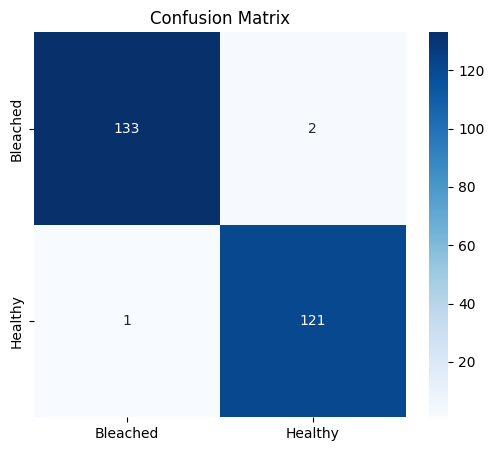

In [10]:
y_prob = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config.CLASSES, yticklabels=config.CLASSES)
plt.title("Confusion Matrix")
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix.png'), dpi=200)
plt.show()

In [11]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=config.CLASSES))


Classification Report:
              precision    recall  f1-score   support

    Bleached       0.99      0.99      0.99       135
     Healthy       0.98      0.99      0.99       122

    accuracy                           0.99       257
   macro avg       0.99      0.99      0.99       257
weighted avg       0.99      0.99      0.99       257



### ROC CURVE

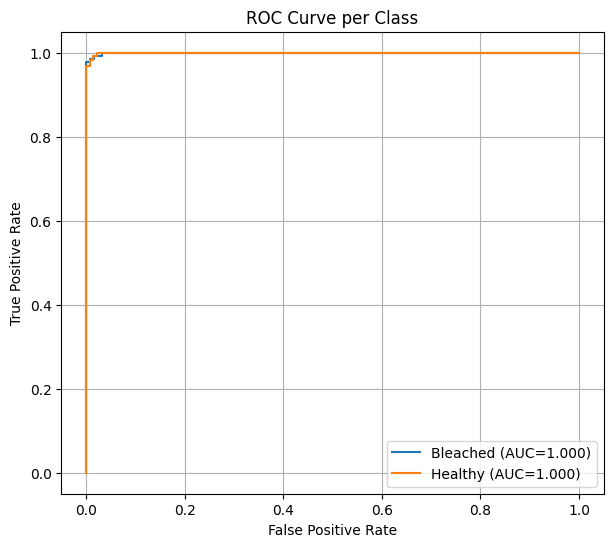

In [12]:
y_true_bin = keras.utils.to_categorical(y_true, num_classes=config.NUM_CLASSES)
plt.figure(figsize=(7,6))
for i, name in enumerate(config.CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class')
plt.legend()
plt.grid()
plt.savefig(os.path.join(config.RESULTS_DIR, 'roc_curve.png'), dpi=200)
plt.show()

### TRAIN–VALIDATION–TEST SUMMARY

In [13]:
import pandas as pd
print("\n=== Training History Summary ===")
history_df = pd.DataFrame(history.history)
print(history_df.tail())


=== Training History Summary ===
    accuracy      loss  precision    recall  val_accuracy  val_loss  \
25  0.994825  0.016037   0.994825  0.994825      0.984881  0.040059   
26  0.994308  0.017349   0.994308  0.994308      0.991361  0.040216   
27  0.994515  0.017954   0.994515  0.994515      0.993520  0.034384   
28  0.994101  0.018897   0.994101  0.994101      0.987041  0.043412   
29  0.995964  0.012171   0.995964  0.995964      0.989201  0.041254   

    val_precision  val_recall  learning_rate  
25       0.984881    0.984881       0.000006  
26       0.991361    0.991361       0.000006  
27       0.993520    0.993520       0.000006  
28       0.987041    0.987041       0.000006  
29       0.989201    0.989201       0.000006  


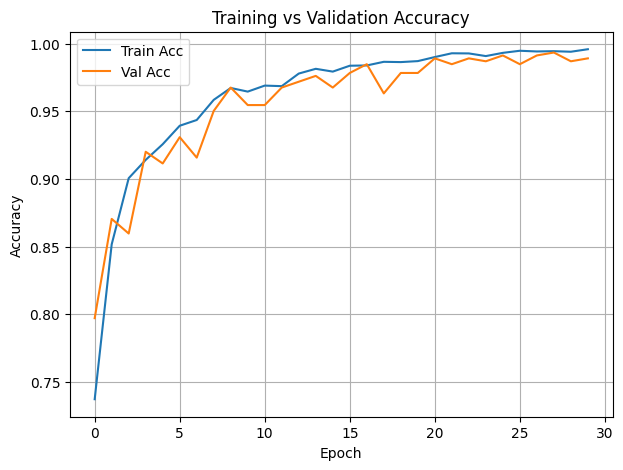

In [14]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.savefig(os.path.join(config.RESULTS_DIR, 'plot_accuracy.png'), dpi=200)
plt.show()

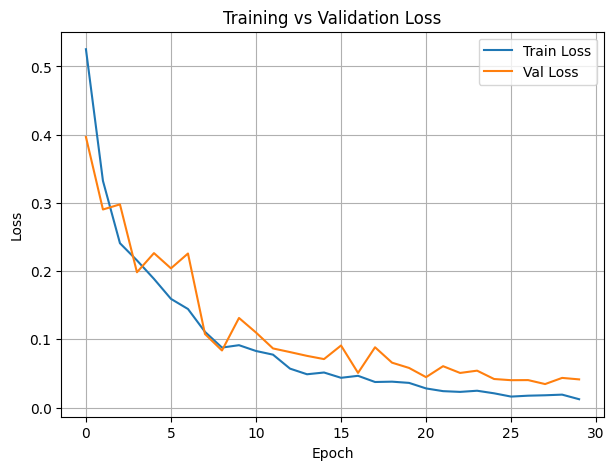

In [15]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.savefig(os.path.join(config.RESULTS_DIR, 'plot_loss.png'), dpi=200)
plt.show()

In [16]:
summary = {
    "Metric": ["Loss", "Accuracy", "Precision", "Recall"],
    "Train": [
        history.history["loss"][-1],
        history.history["accuracy"][-1],
        history.history["precision"][-1],
        history.history["recall"][-1]],
    "Validation": [
        history.history["val_loss"][-1],
        history.history["val_accuracy"][-1],
        history.history["val_precision"][-1],
        history.history["val_recall"][-1]],
    "Test": [
        results[0],
        results[1],
        results[2],
        results[3]]}
summary_df = pd.DataFrame(summary)

In [17]:
print("\n=== TRAIN - VALIDATION - TEST SUMMARY ===")
summary_df


=== TRAIN - VALIDATION - TEST SUMMARY ===


,Metric,Train,Validation,Test
0,Loss,0.012171,0.041254,0.035962
1,Accuracy,0.995964,0.989201,0.988327
2,Precision,0.995964,0.989201,0.988327
3,Recall,0.995964,0.989201,0.988327


### 

### PREDICTION

Generating sample predictions


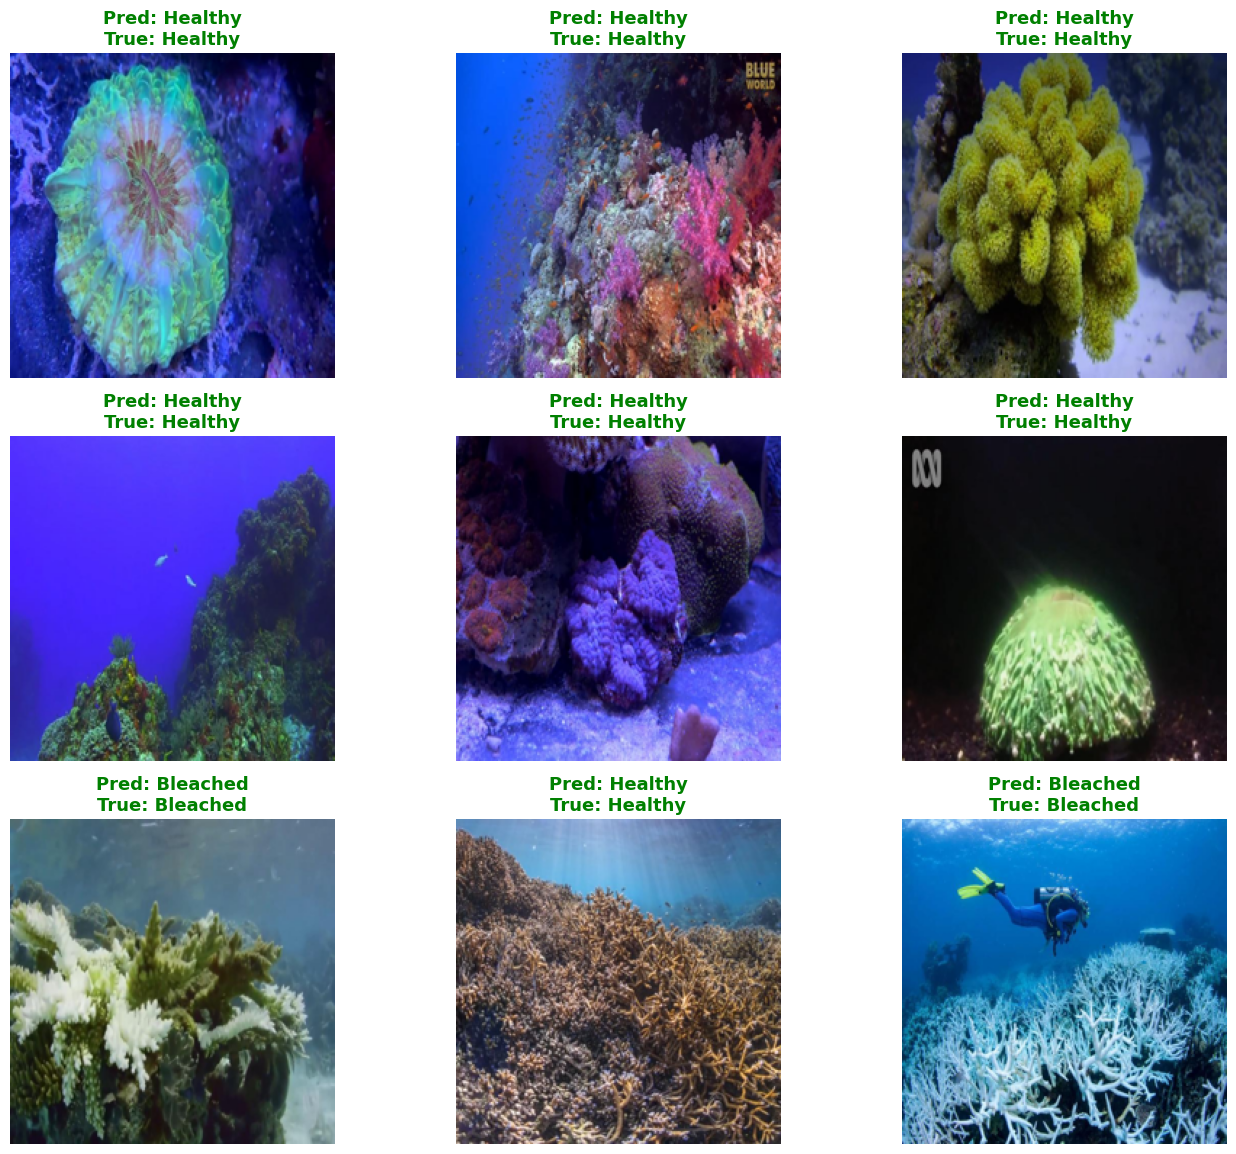

In [25]:
print("Generating sample predictions")
import random
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}
sample_images = random.sample(test_gen.filenames, 9)
plt.figure(figsize=(14, 12))
for i, img_path in enumerate(sample_images):
    img_full_path = os.path.join(config.TEST_DIR, img_path)
    img = Image.open(img_full_path).resize((config.IMG_SIZE, config.IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prob = best_model.predict(img_array, verbose=0)[0]
    pred_idx = np.argmax(prob)
    pred_label = idx_to_class[pred_idx]
    pred_conf = prob[pred_idx]
    if "\\" in img_path:
        true_label = img_path.split("\\")[0]
    else:
        true_label = img_path.split("/")[0]
    color = "green" if pred_label == true_label else "red"
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(
        f"Pred: {pred_label}\nTrue: {true_label}",
        fontsize=13,
        fontweight="bold",
        color=color)
    plt.xlabel(f"Confidence: {pred_conf:.2f}", fontsize=11, color=color)
    plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### SAVE MODEL  

In [ ]:
model.save(config.MODEL_PATH)
print("Model saved as:", config.MODEL_PATH)
import pickle
metadata = {
    "img_size": config.IMG_SIZE,
    "class_indices": train_gen.class_indices,
    "classes": config.CLASSES}
with open("model_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)
print("Metadata saved as model_metadata.pkl")

Model saved as: models/coral_vit_lite_best.keras
Metadata saved as model_metadata.pkl
